In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from prometheus_pandas import query
from IPython.display import Markdown, display
import urllib.parse
from scipy.signal import argrelmax

p = query.Prometheus('http://192.168.178.67:9090')
DEFAULT_STEP="1s"

DEBUG=False

# We're scraping much more data than we actually need.
# This is especially true for devices.
# In this section we define which devices we actually want to analyze.
NET_DEVICES=["docker0","enp7s0","lo"]
DISK_DEVICES=["sda"]
# The default range for sliding window aggregations
DEFAULT_RANGE="10s"

# This is going to be the label filter we're going to use
net_filter_label = f"{{device=~\"{'|'.join(NET_DEVICES)}\"}}"
# This is going to be the label filter we're going to use
disk_filter_label = f"{{device=~\"{'|'.join(DISK_DEVICES)}\"}}"
interrupts_filter = "{devices=\"\"}"

# Styling
sns.set_theme(style="ticks",palette="tab10")
sns.set_style("ticks",{'axes.grid' : True})

# Utils

In [107]:
def fetch_query_range(query, start, end, step=DEFAULT_STEP, offset_start=0, offset_end=0):
    start = start + offset_start
    end = end - offset_end
    if DEBUG:
        url = f"{p.api_url}/api/v1/query_range?query={urllib.parse.quote(query.encode('utf8'))}&start={start}&end={end}&step={step}"
        print(f"Querying '{query}' from {start} to {end} with step {step}: {url}")
    return p.query_range(query, start, end, step)

def prepare_query_range_as_dataframe(query, start, end, step=DEFAULT_STEP, offset_start=0, offset_end=0) -> pd.DataFrame:
    # url = f"{p.api_url}/api/v1/query_range?query={urllib.parse.quote(query.encode('utf8'))}&start={start}&end={end}&step={step}"
    # print(f"[Measurement {measurement_no}] Querying '{query}' from {start} to {end} with step {step}: {url}")
    # metrics = p.query_range(query, start, end, step)
    metrics = fetch_query_range(query, start, end, step, offset_start, offset_end)

    # We can't be sure that we have a value for each second, so we calculate the difference between the timestamps
    # and att those to the dataframe
    metrics['tvalue'] = metrics.index
    metrics['delta'] = (metrics['tvalue'] - metrics['tvalue'].min()).fillna(0).astype('timedelta64[s]')
    metrics['seconds'] = metrics['delta'].dt.total_seconds().astype(int)
    metrics.drop(['tvalue'], inplace=True, axis=1)
    
    # summarize_outliers(metrics.reset_index())
    
    return metrics


def prepare_dataframe(query, df, offset_start=0, offset_end=0):
    result = [prepare_query_range_as_dataframe(query, start, end, offset_start=offset_start, offset_end=offset_end).assign(idx=idx) for idx, (start, end) in enumerate(zip(df['Start'], df['End']), 1)]
    result = pd.concat(result)
    return result

# Data Preparation

In [108]:
Q_POWER='{__name__=~"epc1202PowerActive|epc1202Current|epc1202Voltage"}'
Q_CPU_SECONDS=f"sum by (mode) (increase(node_cpu_seconds_total[{DEFAULT_RANGE}]))"
Q_CPU_UTILIZATION=f"avg by (mode) (rate(node_cpu_seconds_total[{DEFAULT_RANGE}]) * 100)"
Q_CPU_FREQUENCY="avg by (instance) (node_cpu_scaling_frequency_hertz)"
Q_MEMORY_USAGE=f"""
      100 * (1 - ((avg_over_time(node_memory_MemFree_bytes[{DEFAULT_RANGE}]) + avg_over_time(node_memory_Cached_bytes[{DEFAULT_RANGE}]) + avg_over_time(node_memory_Buffers_bytes[{DEFAULT_RANGE}])) / avg_over_time(node_memory_MemTotal_bytes[{DEFAULT_RANGE}])))
    """
Q_NETWORK_RX_BYTES=f"sum by(device) (increase(node_network_receive_bytes_total{net_filter_label}[{DEFAULT_RANGE}])) / 1000"
Q_NETWORK_TX_BYTES=f"sum by(device) (increase(node_network_transmit_bytes_total{net_filter_label}[{DEFAULT_RANGE}])) / 1000"
Q_NETWORK_RX_PACKETS=f"sum by(device) (increase(node_network_receive_packets_total{net_filter_label}[{DEFAULT_RANGE}])) / 1000"
Q_NETWORK_TX_PACKETS=f"sum by(device) (increase(node_network_transmit_packets_total{net_filter_label}[{DEFAULT_RANGE}])) / 1000"
Q_NETWORK_RX_RATE=f"avg by (device) (rate(node_network_receive_bytes_total{net_filter_label}[{DEFAULT_RANGE}]))"
Q_NETWORK_TX_RATE=f"avg by (device) (rate(node_network_transmit_bytes_total{net_filter_label}[{DEFAULT_RANGE}]))"
Q_DISK_IO_SECONDS=f"node_disk_io_time_seconds_total{disk_filter_label}"
Q_DISK_IO_RATE=f"avg by (device) (rate(node_disk_io_time_seconds_total{disk_filter_label}[{DEFAULT_RANGE}]))"
Q_INTERRUPTS=f"sum by (devices, type) (idelta(node_interrupts_total{interrupts_filter}[{DEFAULT_RANGE}]) > 0)"

In [109]:
# This is just a try to load everything into a single dataframe.
# It's not working yet, but I'm going to leave it here for now.
def prepare_humongous_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    power_metrics = prepare_dataframe(Q_POWER, df).set_index(['measurement', 'seconds'])
    cpu_seconds = prepare_dataframe("avg by (mode) (node_cpu_seconds_total)", df).set_index(['measurement', 'seconds'])
    memory_free = prepare_dataframe("node_memory_MemFree_bytes", df).set_index(['measurement','seconds'])
    memory_chached = prepare_dataframe("node_memory_Cached_bytes", df).set_index(['measurement','seconds'])
    memory_buffers = prepare_dataframe("node_memory_Buffers_bytes", df).set_index(['measurement', 'seconds'])
    memory_total = prepare_dataframe("node_memory_MemTotal_bytes", df).set_index(['measurement', 'seconds'])
    network_receive_bytes = prepare_dataframe(f"node_network_receive_bytes_total{net_filter_label}", df).set_index(['measurement', 'seconds'])
    network_transmit_bytes = prepare_dataframe(f"node_network_transmit_bytes{net_filter_label}", df).set_index(['measurement', 'seconds'])
    disk_io_time_seconds = prepare_dataframe(f"node_disk_io_time_seconds_total{disk_filter_label}", df).set_index(['measurement', 'seconds'])
    interrupts = prepare_dataframe(f"sum by(devices, type) (node_interrupts_total{interrupts_filter} > 0)", df).set_index(['measurement', 'seconds'])

    df = pd.concat(
        [power_metrics, cpu_seconds, memory_free, memory_chached, memory_buffers, memory_total, network_receive_bytes, network_transmit_bytes, disk_io_time_seconds, interrupts], 
        axis=1,
        names=['measurement', 'seconds']
    )

    return df

# Scaling

In this section we will take a look how system properties scale to energy usages.
Several Benchmarks have been used to measure the factors

## CPU Usage

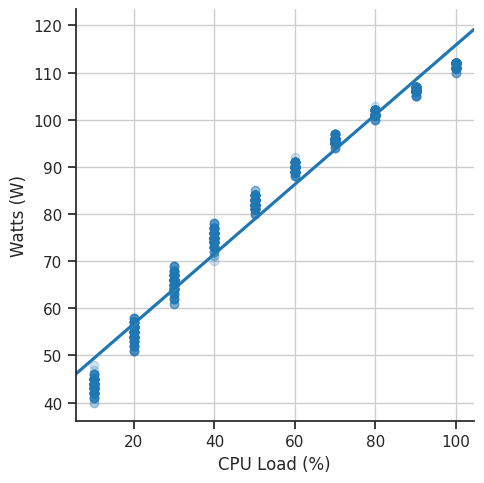

In [110]:
cpu_results = pd.read_csv('base/cpubench/cpubench-log.csv')
power_metrics = pd.concat([
    fetch_query_range(Q_POWER, start, end, offset_start=5, offset_end=5).assign(idx=idx) for idx, (start, end) in enumerate(zip(cpu_results['Start'], cpu_results['End']), 0)
    ])
power_metrics.columns.values[0] = "Current"
power_metrics.columns.values[1] = "Watts"
power_metrics.columns.values[2] = "Voltage"

cpu_results = power_metrics.join(cpu_results, on='idx')
cpu_results=cpu_results.reset_index()[['Watts', 'CPU Load']]
# sns.catplot(
#     data=io_results, x="read_iops", y="Watts", native_scale=True, zorder=1
# )
fg = sns.lmplot(
    data=cpu_results, x="CPU Load", y="Watts", scatter=True, truncate=False, scatter_kws={'alpha': .2}
)
fg.set_axis_labels("CPU Load (%)", "Watts (W)")
plt.show(fg)

## Memory Usage

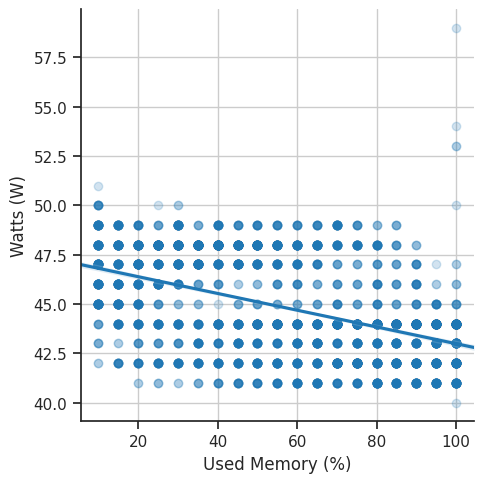

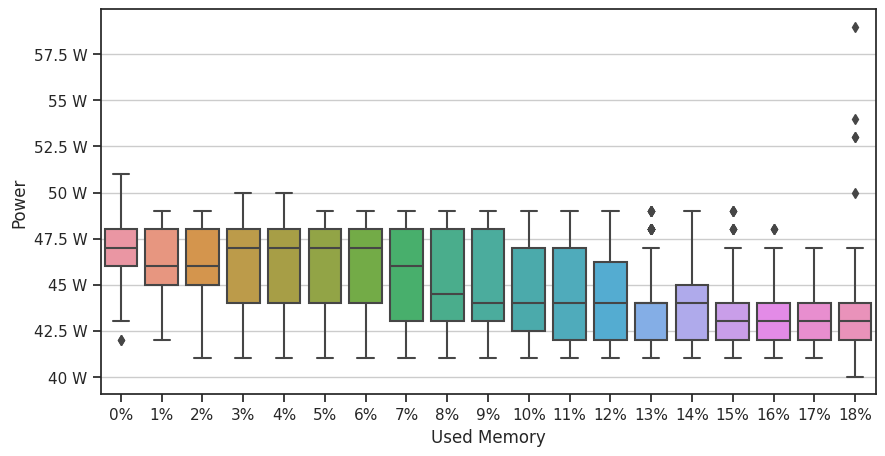

In [111]:
memory_results = pd.read_csv('base/membench/membench-log.csv')
memory_results['Used Memory'] = 100 * memory_results['Used Memory']
power_metrics = pd.concat([
    fetch_query_range(Q_POWER, start, end, offset_start=5, offset_end=5).assign(idx=idx) for idx, (start, end) in enumerate(zip(memory_results['Start'], memory_results['End']), 0)
    ])
power_metrics.columns.values[0] = "Current"
power_metrics.columns.values[1] = "Watts"
power_metrics.columns.values[2] = "Voltage"

memory_results = power_metrics.join(memory_results, on='idx')
memory_results=memory_results.reset_index()[['Watts', 'Used Memory']]
# sns.catplot(
#     data=io_results, x="read_iops", y="Watts", native_scale=True, zorder=1
# )
fg = sns.lmplot(
    data=memory_results, x="Used Memory", y="Watts", scatter=True, truncate=False, scatter_kws={'alpha': .2}
)
fg.set_axis_labels("Used Memory (%)", "Watts (W)")
plt.show(fg)

fig = plt.figure(figsize=(10, 5))
ax = sns.boxplot(
    data=memory_results, x="Used Memory", y="Watts"
)
#ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=100, decimals=0))
ax.yaxis.set_major_formatter(ticker.EngFormatter(unit='W'))
ax.set(xlabel="Used Memory", ylabel="Power")
plt.show(fig)


## Disk I/O

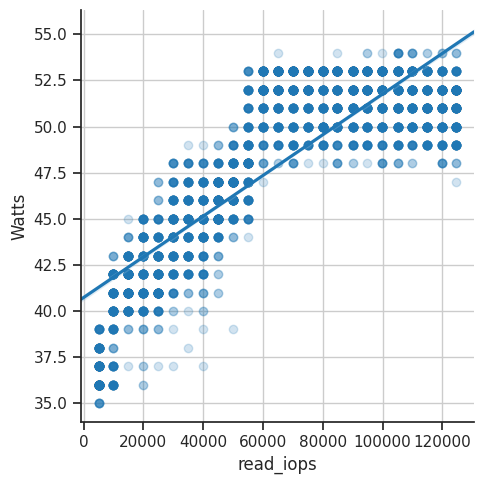

In [112]:
# Disk I/O
IO_RESULTS = pd.read_csv('base/iobench/iobench.csv', sep=';')
power_metrics = pd.concat([
    fetch_query_range(Q_POWER, start, end, offset_start=5, offset_end=5).assign(idx=idx) for idx, (start, end) in enumerate(zip(IO_RESULTS['Start'], IO_RESULTS['End']), 0)
    ])
power_metrics.columns.values[0] = "Current"
power_metrics.columns.values[1] = "Watts"
power_metrics.columns.values[2] = "Voltage"

s_io_results = power_metrics.join(IO_RESULTS, on='idx')
s_io_results=s_io_results.reset_index()[['Watts', 'read_iops']]
# sns.catplot(
#     data=io_results, x="read_iops", y="Watts", native_scale=True, zorder=1
# )
fg = sns.lmplot(
    data=s_io_results, x="read_iops", y="Watts", scatter=True, truncate=False, scatter_kws={'alpha': .2}
)
plt.show(fg)

## Network I/O

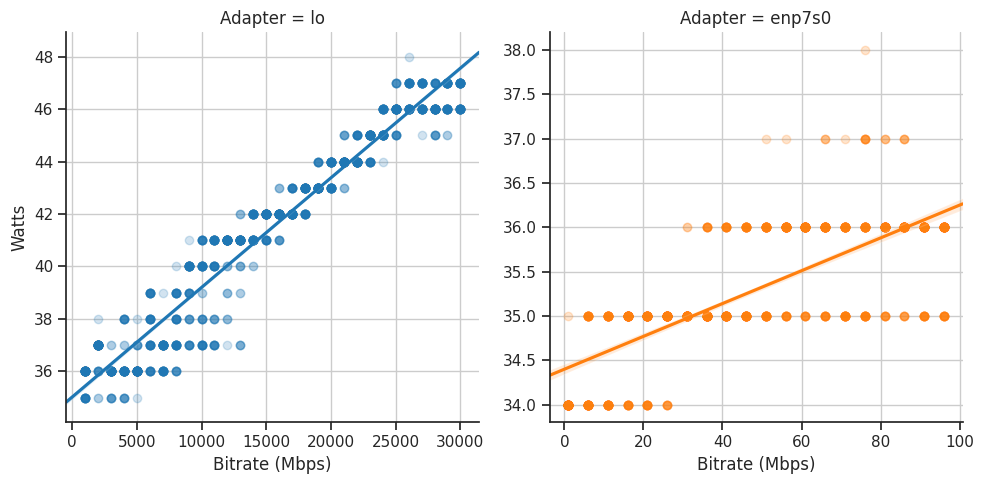

In [113]:
NET_RESULTS = pd.read_csv('base/netbench/netbench-log.csv', sep=',')
power_metrics = pd.concat([
    fetch_query_range(Q_POWER, start, end, offset_start=5, offset_end=5).assign(idx=idx) for idx, (start, end) in enumerate(zip(NET_RESULTS['Start'], NET_RESULTS['End']), 0)
    ])
power_metrics.columns.values[0] = "Current"
power_metrics.columns.values[1] = "Watts"
power_metrics.columns.values[2] = "Voltage"

s_net_results = power_metrics.join(NET_RESULTS, on='idx')

s_net_results=s_net_results.reset_index()[['Watts', 'Bitrate', 'Adapter']]
s_net_results['Bitrate'] = s_net_results['Bitrate'].astype(float).div(1000000) # To Mbps

fg = sns.lmplot(
    data=s_net_results, x="Bitrate", y="Watts", hue="Adapter", col="Adapter", scatter=True, truncate=False, scatter_kws={'alpha': .2},
    facet_kws=dict(sharex=False, sharey=False),
)
fg.axes[0,0].set_xlabel('Bitrate (Mbps)')
fg.axes[0,1].set_xlabel('Bitrate (Mbps)')
plt.show(fg)

## Summary

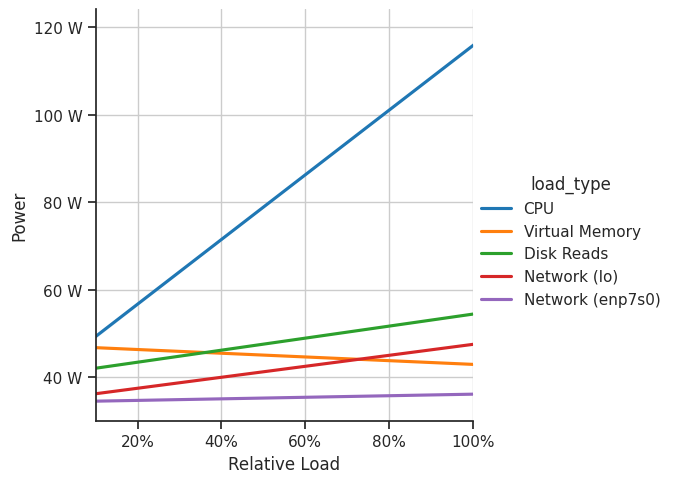

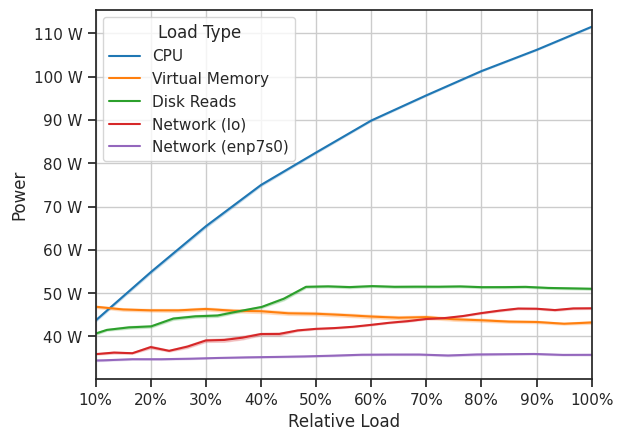

In [114]:
relative_cpu_results=cpu_results
relative_cpu_results['rel_load']=cpu_results['CPU Load'] / cpu_results['CPU Load'].max() * 100
relative_cpu_results=relative_cpu_results.assign(load_type='CPU')

relative_memory_results=memory_results
relative_memory_results['rel_load']=memory_results['Used Memory'] / memory_results['Used Memory'].max() * 100
relative_memory_results=relative_memory_results.assign(load_type='Virtual Memory')

relative_io_results=s_io_results
relative_io_results['rel_load']=s_io_results['read_iops'] / s_io_results['read_iops'].max() * 100
relative_io_results=relative_io_results.assign(load_type='Disk Reads')

relative_net_results=s_net_results
relative_net_results['rel_load']=relative_net_results.groupby('Adapter')['Bitrate'].transform(lambda x: x / x.max() * 100)
relative_net_results=relative_net_results.reset_index()
relative_net_results['load_type'] = relative_net_results.apply(lambda row: f"Network ({row['Adapter']})", axis=1)

# Watts | Relative Load | Type
relative_results = pd.concat([
    relative_cpu_results[['rel_load', 'Watts', 'load_type']],
    relative_memory_results[['rel_load', 'Watts', 'load_type']],
    relative_io_results[['rel_load', 'Watts', 'load_type']], 
    relative_net_results[['rel_load', 'Watts', 'load_type']]
])

fg = sns.lmplot(
    data=relative_results, x="rel_load", y="Watts", hue="load_type", scatter=False, truncate=False
)
fg.axes[0,0].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=100, decimals=0))
fg.axes[0,0].yaxis.set_major_formatter(ticker.EngFormatter(unit='W'))
fg.axes[0,0].set_xlim(10, 100)
fg.axes[0,0].set_xlabel('Relative Load')
fg.axes[0,0].set_ylabel('Power')
plt.show(fg)

fig, ax = plt.subplots()  
sns.lineplot(
    ax=ax,
    data=relative_results, x="rel_load", y="Watts", hue="load_type"
)
ax.yaxis.set_major_formatter(ticker.EngFormatter(unit='W'))
ax.set_xlim(10, 100)
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=100, decimals=0))
ax.set_xlabel("Relative Load")
ax.set_ylabel("Power")
ax.legend(title='Load Type')
plt.show(fig)

/tmp/ipykernel_7873/387653195.py:38: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in fg._legend.legendHandles:


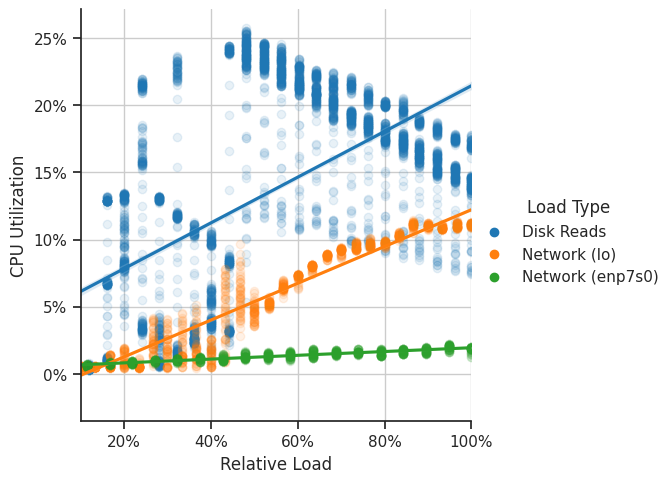

In [115]:
net_cpu_utilization = pd.concat([
    fetch_query_range(Q_CPU_UTILIZATION, start, end, offset_start=5, offset_end=5).assign(idx=idx) for idx, (start, end) in enumerate(zip(NET_RESULTS['Start'], NET_RESULTS['End']), 0)
])
net_cpu_utilization = net_cpu_utilization.join(NET_RESULTS, on='idx')
net_cpu_utilization.drop(columns=['{mode="idle"}'], inplace=True)
net_cpu_utilization['utilization'] = net_cpu_utilization.iloc[:, 1:7].sum(axis=1)
net_cpu_utilization['rel_load']=net_cpu_utilization.groupby('Adapter')['Bitrate'].transform(lambda x: x / x.max() * 100)
net_cpu_utilization['load_type'] = net_cpu_utilization.apply(lambda row: f"Network ({row['Adapter']})", axis=1)
net_cpu_utilization=net_cpu_utilization.reset_index()

io_cpu_utilization = pd.concat([
    fetch_query_range(Q_CPU_UTILIZATION, start, end, offset_start=5, offset_end=5).assign(idx=idx) for idx, (start, end) in enumerate(zip(IO_RESULTS['Start'], IO_RESULTS['End']), 0)
])
io_cpu_utilization = io_cpu_utilization.join(IO_RESULTS, on='idx')
io_cpu_utilization.drop(columns=['{mode="idle"}'], inplace=True)
io_cpu_utilization['utilization'] = io_cpu_utilization.iloc[:, 1:7].sum(axis=1)
io_cpu_utilization['rel_load']=io_cpu_utilization['read_iops'] / io_cpu_utilization['read_iops'].max() * 100
io_cpu_utilization=io_cpu_utilization.assign(load_type='Disk Reads')
io_cpu_utilization=io_cpu_utilization.reset_index()

relative_results = pd.concat([
    io_cpu_utilization[['rel_load', 'utilization', 'load_type']],
    net_cpu_utilization[['rel_load', 'utilization', 'load_type']]
])

fg = sns.lmplot(
    data=relative_results, x="rel_load", y="utilization", hue="load_type", 
    scatter=True, truncate=False, scatter_kws={'alpha': .1}
)
ax = fg.axes[0,0]
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=100, decimals=0))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=100, decimals=0))
ax.set_xlim(10, 100)
ax.set_xlabel("Relative Load")
ax.set_ylabel("CPU Utilization")
fg._legend.set_title('Load Type')

for lh in fg._legend.legendHandles:
    lh.set_alpha(1)

plt.show(fg)

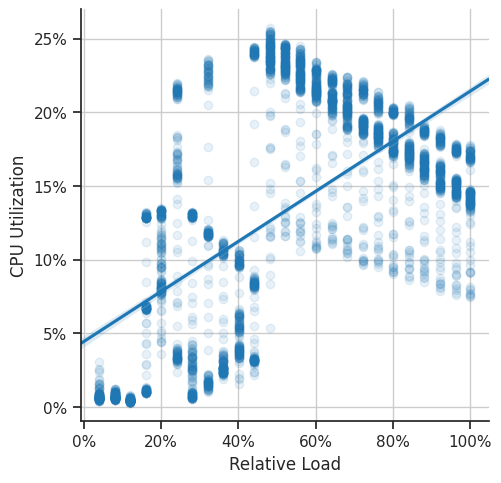

In [116]:
io_cpu_utilization = pd.concat([
    fetch_query_range(Q_CPU_UTILIZATION, start, end, offset_start=5, offset_end=5).assign(idx=idx) for idx, (start, end) in enumerate(zip(IO_RESULTS['Start'], IO_RESULTS['End']), 0)
])
io_cpu_utilization = io_cpu_utilization.join(IO_RESULTS, on='idx')
io_cpu_utilization.drop(columns=['{mode="idle"}'], inplace=True)
io_cpu_utilization['utilization'] = io_cpu_utilization.iloc[:, 1:7].sum(axis=1)
io_cpu_utilization['rel_load']=io_cpu_utilization['read_iops'] / io_cpu_utilization['read_iops'].max() * 100
io_cpu_utilization=io_cpu_utilization.reset_index()
#display(io_cpu_utilization)


fg = sns.lmplot(
    data=io_cpu_utilization, x="rel_load", y="utilization", 
    scatter=True, truncate=False, scatter_kws={'alpha': .1}
)
ax = fg.axes[0,0]
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=100, decimals=0))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=100, decimals=0))
ax.set_xlabel("Relative Load")
ax.set_ylabel("CPU Utilization")

plt.show(fg)

# Baseline Analysis

Here we take a look at the Baseline of our DUT


In [117]:
bm = pd.read_csv('base/baseline.csv')
bm

,Start,End,Duration,Energy
0,1682782920,1682783220,5m,2


## Power Stats

count    301.000000
mean      33.006645
std        0.081378
min       33.000000
25%       33.000000
50%       33.000000
75%       33.000000
max       34.000000
Name: Watts, dtype: float64

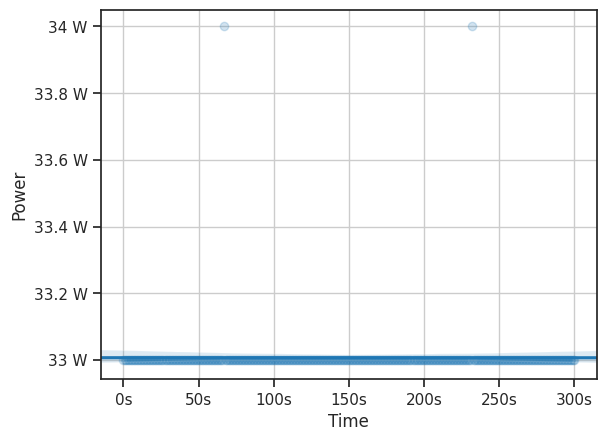

In [118]:
power_metrics = pd.concat([
    prepare_query_range_as_dataframe(Q_POWER, start, end).assign(idx=idx) for idx, (start, end) in enumerate(zip(bm['Start'], bm['End']), 0)
    ])
power_metrics.columns.values[0] = "Current"
power_metrics.columns.values[1] = "Watts"
power_metrics.columns.values[2] = "Voltage"

display(power_metrics['Watts'].describe())

fg = sns.regplot(
    data=power_metrics, x="seconds", y="Watts", scatter=True, truncate=False,
    scatter_kws={'alpha': .2}
)
fg.axes.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.0f}s'))
fg.axes.yaxis.set_major_formatter(ticker.EngFormatter(unit='W'))
fg.axes.set_xlabel('Time')
fg.axes.set_ylabel('Power')
plt.show(fg)

# Case Study 1: Caching

In [119]:
# Those are the variants we have measured
CACHE_VARIANTS=["no-cache", "caffeine-cache", "redis-cache"]
data_measurement = pd.read_csv("case-study-caching/benchmark-log.csv")

In [120]:
POWER_METRICS = pd.concat([prepare_dataframe(Q_POWER, data_measurement.loc[data_measurement['Variant'] == v]).assign(variant=v) for v in CACHE_VARIANTS])
POWER_METRICS.columns.values[0] = "Power"
POWER_METRICS.columns.values[1] = "Watts"
POWER_METRICS.columns.values[2] = "Voltage"

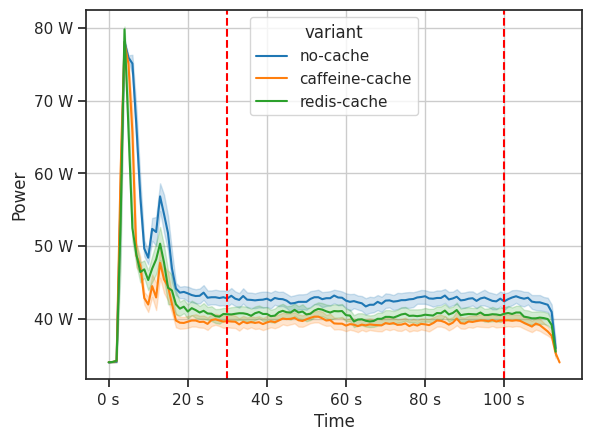

In [121]:
# We take a look at the measurements over time and see that we have an initializing and a finalizing phase. 
# We will cut those out and only look at the measurements in between.
f = plt.figure()
ax = sns.lineplot(
    data=POWER_METRICS, x="seconds", y="Watts", hue="variant"
)

SECONDS_MIN=30
SECONDS_MAX=100

ax.yaxis.set_major_formatter(ticker.EngFormatter(unit='W'))
ax.xaxis.set_major_formatter(ticker.EngFormatter(unit='s'))
plt.axvline(x=SECONDS_MIN, color='r', linestyle='--')
plt.axvline(x=SECONDS_MAX, color='r', linestyle='--')
#plt.annotate(text='', xy=(SECONDS_MIN,60), xytext=(SECONDS_MAX,60), arrowprops=dict(arrowstyle='<->', ls='dashed', lw=2,  color='red'))
ax.set_xlabel("Time")
ax.set_ylabel("Power")
plt.show()

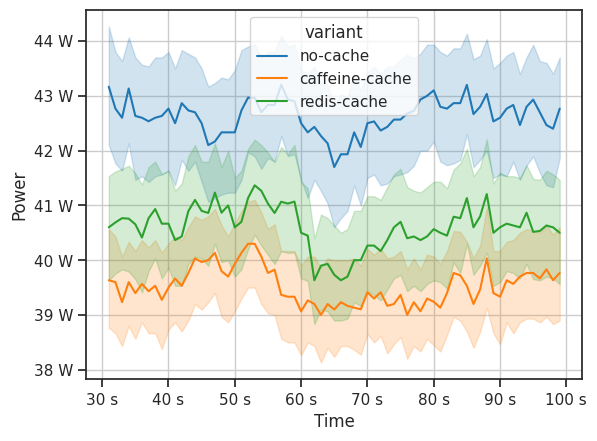

,count,mean,std,min,25%,50%,75%,max
variant,,,,,,,,
caffeine-cache,2063.0,39.525448,2.300257,37.0,37.0,39.0,42.0,47.0
no-cache,2063.0,42.628211,2.886626,38.0,39.0,45.0,45.0,50.0
redis-cache,2057.0,40.602820,2.592876,38.0,38.0,39.0,43.0,47.0


In [122]:
POWER_METRICS_INTERVAL = POWER_METRICS.loc[(POWER_METRICS['seconds'] > SECONDS_MIN) & (POWER_METRICS['seconds'] < SECONDS_MAX)]
ax = sns.lineplot(
    data=POWER_METRICS_INTERVAL, x="seconds", y="Watts", hue="variant"
)
ax.yaxis.set_major_formatter(ticker.EngFormatter(unit='W'))
ax.xaxis.set_major_formatter(ticker.EngFormatter(unit='s'))
ax.set_xlabel("Time")
ax.set_ylabel("Power")
plt.show()

display(POWER_METRICS_INTERVAL.groupby(by=['variant'])['Watts'].describe())

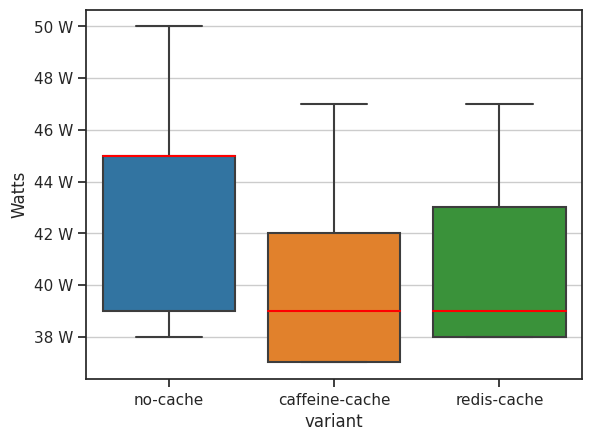

In [123]:
f, ax = plt.subplots()
sns.boxplot(x="variant", y="Watts", data=POWER_METRICS_INTERVAL, medianprops=dict(color='r'))
# sns.stripplot(x="Watts", y="variant", data=POWER_METRICS_INTERVAL, size=4, color=".3", linewidth=0, alpha=.5)
ax.yaxis.set_major_formatter(ticker.EngFormatter(unit='W'))
plt.show()

,count,mean,std,min,25%,50%,75%,max
variant,,,,,,,,
caffeine-cache,2070.0,11.097484,1.389300,7.715278,9.923611,11.270833,12.220486,14.631944
no-cache,2070.0,17.368418,1.484093,14.312500,16.111111,16.819444,18.907986,20.520833
redis-cache,2070.0,15.085970,1.506774,11.465278,13.736111,15.506944,16.409722,17.909722


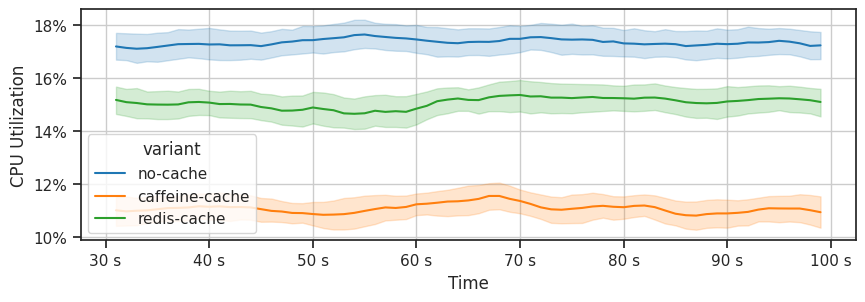

In [125]:
CPU_UTILIZATION = pd.concat(
    [prepare_dataframe(Q_CPU_UTILIZATION, data_measurement.loc[data_measurement['Variant'] == v]).assign(variant=v) for v in CACHE_VARIANTS]
    )
# Remember we want to cut out the initializing and finalizing phase
CPU_UTILIZATION = CPU_UTILIZATION.loc[(CPU_UTILIZATION['seconds'] > SECONDS_MIN) & (CPU_UTILIZATION['seconds'] < SECONDS_MAX)]
# We don't care
#CPU_UTILIZATION.drop(columns=['{mode="idle"}', 'delta'], inplace=True)
CPU_UTILIZATION['utilization'] = CPU_UTILIZATION.loc[:, ['{mode="iowait"}', '{mode="irq"}', '{mode="nice"}', '{mode="softirq"}', '{mode="steal"}', '{mode="system"}','{mode="user"}']].sum(axis=1)
CPU_UTILIZATION = CPU_UTILIZATION.loc[:, ['seconds', 'variant', 'utilization']]

display(CPU_UTILIZATION.groupby(by=['variant'])['utilization'].describe())
f = plt.figure(figsize=(10,3))
ax = sns.lineplot(
    data=CPU_UTILIZATION, x="seconds", y="utilization", hue="variant"
)
ax.xaxis.set_major_formatter(ticker.EngFormatter(unit='s'))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=100, decimals=0))
ax.set_xlabel("Time")
ax.set_ylabel("CPU Utilization")
plt.show(f)

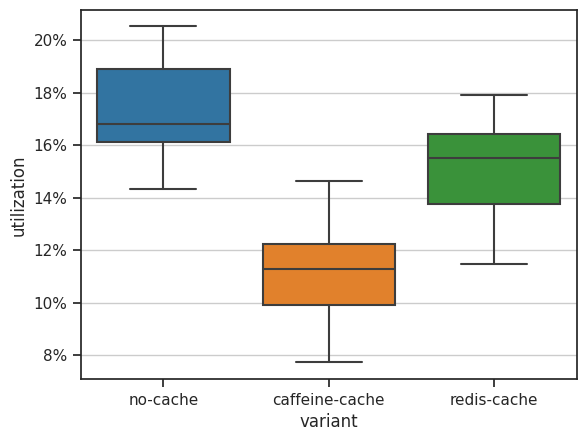

In [127]:
f, ax = plt.subplots()
sns.boxplot(x="variant", y="utilization", data=CPU_UTILIZATION)
# sns.stripplot(x="Watts", y="variant", data=POWER_METRICS_INTERVAL, size=4, color=".3", linewidth=0, alpha=.5)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=100, decimals=0))
plt.show()

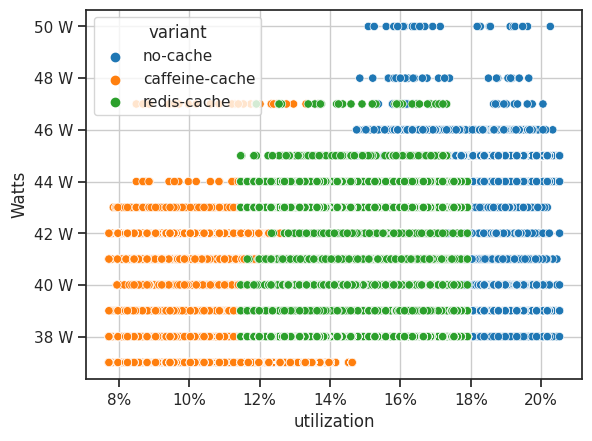

In [130]:
# Now we want to see how the CPU utilization relates to the power consumption
CPU_POWER = pd.merge(CPU_UTILIZATION, POWER_METRICS_INTERVAL, on=['seconds', 'variant'])
CPU_POWER['Watts'] = CPU_POWER['Watts'].astype(float)
CPU_POWER['utilization'] = CPU_POWER['utilization'].astype(float)

f, ax = plt.subplots()
sns.scatterplot(x="utilization", y="Watts", data=CPU_POWER, hue="variant")
ax.yaxis.set_major_formatter(ticker.EngFormatter(unit='W'))
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=100, decimals=0))
plt.show()

In [ ]:
# For the efficiency we want to see how much power we need for a certain amount of requests has been consumed
# In order to do that we need to know how many requests have been processed in the interval
K6_THROUGHPUT = pd.concat(
    [prepare_dataframe("k6_iterations_total", data_measurement.loc[data_measurement['Variant'] == v]).assign(variant=v) for v in CACHE_VARIANTS]
    )
# As the metrc is a resettable Gauge, we can pick the values in our observable range and 
K6_THROUGHPUT = K6_THROUGHPUT.loc[(K6_THROUGHPUT['seconds'] == SECONDS_MIN) | (K6_THROUGHPUT['seconds'] == SECONDS_MAX)]
#K6_THROUGHPUT.columns.values[0] = 'throughput'
K6_THROUGHPUT.rename(columns={'k6_iterations_total{scenario="default"}': 'throughput'}, inplace=True)
K6_THROUGHPUT['throughput'] = K6_THROUGHPUT['throughput'].diff()
K6_THROUGHPUT = K6_THROUGHPUT.loc[(K6_THROUGHPUT['throughput'] > 0)]

K6_THROUGHPUT[['variant', 'throughput']].groupby('variant').describe().round(0)

throughput                                                      
                    count     mean   std      min      25%      50%      75%   
variant                                                                        
caffeine-cache       30.0  51457.0  19.0  51388.0  51457.0  51462.0  51466.0  \
no-cache             30.0  51466.0  24.0  51416.0  51458.0  51465.0  51473.0   
redis-cache          30.0  51451.0  44.0  51323.0  51432.0  51462.0  51474.0   

                         
                    max  
variant                  
caffeine-cache  51492.0  
no-cache        51510.0  
redis-cache     51511.0

,variant,idx,throughput,delta,seconds,Watts,efficiency
0,no-cache,1,51472.0,0 days 00:01:40,100,43.397059,1186.071162
1,no-cache,2,51465.0,0 days 00:01:40,100,41.838235,1230.094903
2,no-cache,3,51473.0,0 days 00:01:40,100,38.925373,1322.350844
3,no-cache,4,51457.0,0 days 00:01:40,100,38.869565,1323.837808
4,no-cache,5,51464.0,0 days 00:01:40,100,43.333333,1187.630769
...,...,...,...,...,...,...,...
85,redis-cache,26,51476.0,0 days 00:01:40,100,41.275362,1247.136236
86,redis-cache,27,51474.0,0 days 00:01:40,100,43.159420,1192.648086
87,redis-cache,28,51461.0,0 days 00:01:40,100,38.582090,1333.805416
88,redis-cache,29,51511.0,0 days 00:01:40,100,39.260870,1312.018826


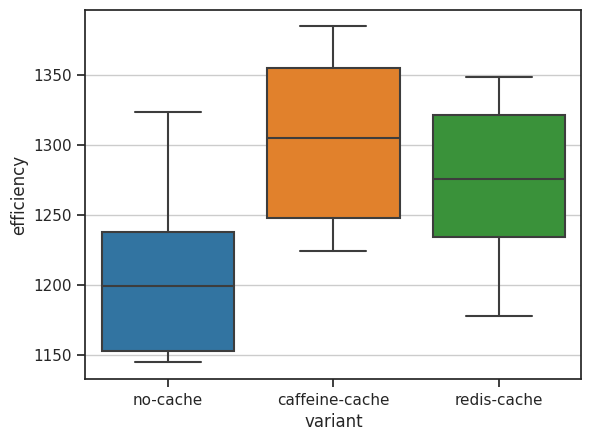

,count,mean,std,min,25%,50%,75%,max
variant,,,,,,,,
caffeine-cache,30.0,1304.13,55.75,1224.52,1248.07,1305.30,1354.78,1384.79
no-cache,30.0,1210.31,60.87,1144.53,1152.48,1199.38,1237.81,1323.84
redis-cache,30.0,1269.66,56.84,1177.76,1234.54,1275.95,1321.31,1348.35


In [134]:
# Now we can calculate the efficiency
# I think we can safeley concat the dataframes as they have the same index
POWER_CONSUMPTION = POWER_METRICS_INTERVAL.groupby(by=['variant', 'idx'])['Watts'].mean().reset_index().set_index(['variant', 'idx'])
USEFUL_WORK = K6_THROUGHPUT.set_index(['variant', 'idx'])

EFFICIENCY = pd.concat([USEFUL_WORK, POWER_CONSUMPTION], axis=1)
EFFICIENCY['efficiency'] = EFFICIENCY['throughput'] / EFFICIENCY['Watts']
EFFICIENCY = EFFICIENCY.reset_index()
display(EFFICIENCY)

f, ax = plt.subplots()
sns.boxplot(x="variant", y="efficiency", data=EFFICIENCY)
plt.show()

EFFICIENCY = EFFICIENCY.groupby(by=['variant'])['efficiency'].describe().round(2)
display(EFFICIENCY)

# Case Study 2: Dungeon

In [ ]:
VARIANTS=["microservice", "monolith"]
data_measurement = pd.read_csv("case-study-dungeon/benchmark-log.csv")

## Power Consumption

### Wattage

,count,mean,std,min,25%,50%,75%,max
variant,,,,,,,,
microservice,4213.0,39.416568,8.439015,34.0,35.0,36.0,39.0,91.0
monolith,4207.0,38.642738,5.753909,34.0,35.0,37.0,39.0,74.0


### See the distribution of the measurements

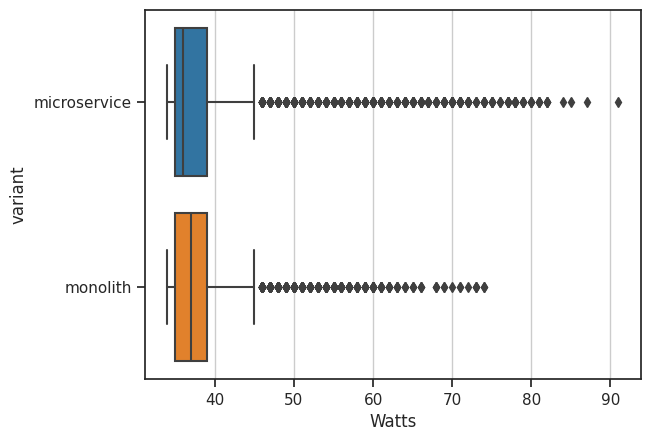

In [ ]:
POWER_METRICS = pd.concat([prepare_dataframe(Q_POWER, data_measurement.loc[data_measurement['Variant'] == v]).assign(variant=v) for v in VARIANTS])
POWER_METRICS.columns.values[0] = "Power"
POWER_METRICS.columns.values[1] = "Watts"
POWER_METRICS.columns.values[2] = "Voltage"

display(Markdown("## Power Consumption"))
POWER_METRICS.reset_index(inplace=True)

# display(Markdown("### Raw Data Samples"))
# display(POWER_METRICS)

display(Markdown("### Wattage"))
display(POWER_METRICS.groupby(by=['variant'])['Watts'].describe())

# Boxplot
display(Markdown("### See the distribution of the measurements"))
f, ax = plt.subplots()
sns.boxplot(x="Watts", y="variant", data=POWER_METRICS)
# sns.stripplot(x="Watts", y="variant", data=POWER_METRICS, size=4, color=".3", linewidth=0, alpha=.5)
plt.show(f)



### See the distribution of Peaks

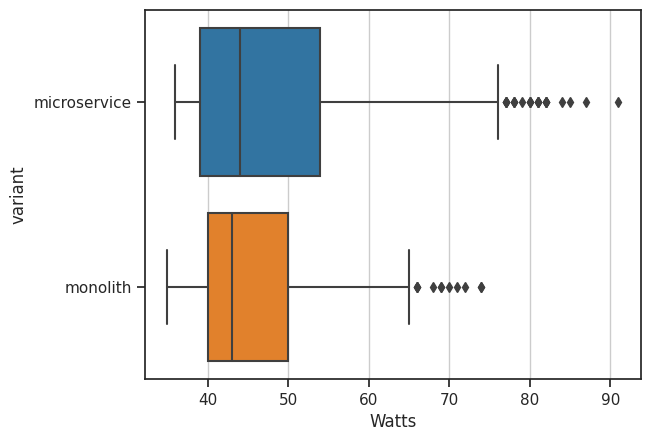

In [ ]:
def get_power_peaks(df, order=1):
    df.columns.values[1] = "Watts"
    return df.iloc[argrelmax(df['Watts'].values, order=order)[0]]

POWER_METRICS_PEAKS = pd.concat([get_power_peaks(prepare_dataframe(Q_POWER, data_measurement.loc[data_measurement['Variant'] == v]).assign(variant=v)) for v in VARIANTS])
POWER_METRICS_PEAKS = POWER_METRICS_PEAKS.loc[:, ['seconds', 'variant', 'Watts']]

# Boxplot
display(Markdown("### See the distribution of Peaks"))
f, ax = plt.subplots()
sns.boxplot(x="Watts", y="variant", data=POWER_METRICS_PEAKS)
# sns.stripplot(x="Watts", y="variant", data=POWER_METRICS, size=4, color=".3", linewidth=0, alpha=.5)
plt.show(f)

,seconds,variant,utilization
2023-04-29 14:56:27,0,microservice,10.493056
2023-04-29 14:56:28,1,microservice,12.402778
2023-04-29 14:56:29,2,microservice,22.041667
2023-04-29 14:56:30,3,microservice,31.555556
2023-04-29 14:56:31,4,microservice,40.138889
...,...,...,...
2023-04-30 02:52:36,586,monolith,7.784722
2023-04-30 02:52:37,587,monolith,9.361111
2023-04-30 02:52:38,588,monolith,10.451389
2023-04-30 02:52:39,589,monolith,10.569444


AttributeError: 'Axes' object has no attribute 'set_xlabels'

<Figure size 1000x300 with 0 Axes>

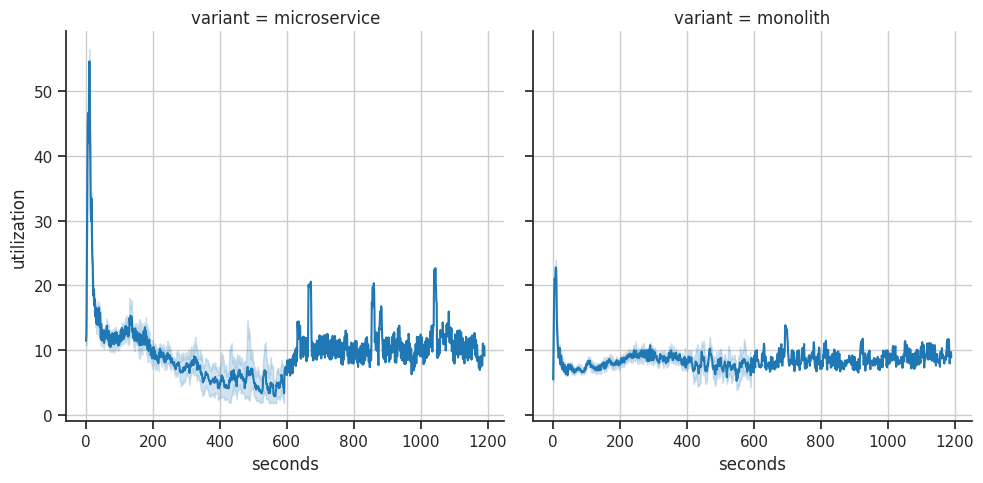

In [ ]:
CPU_UTILIZATION = pd.concat(
    [prepare_dataframe(Q_CPU_UTILIZATION, data_measurement.loc[data_measurement['Variant'] == v], offset_start=5, offset_end=5).assign(variant=v) for v in VARIANTS]
    )
# We don't care
#CPU_UTILIZATION.drop(columns=['{mode="idle"}', 'delta'], inplace=True)
CPU_UTILIZATION['utilization'] = CPU_UTILIZATION.loc[:, ['{mode="iowait"}', '{mode="irq"}', '{mode="nice"}', '{mode="softirq"}', '{mode="steal"}', '{mode="system"}','{mode="user"}']].sum(axis=1)
CPU_UTILIZATION = CPU_UTILIZATION.loc[:, ['seconds', 'variant', 'utilization']]

display(CPU_UTILIZATION)
f = plt.figure(figsize=(10,3))
sns.relplot(
    data=CPU_UTILIZATION, x="seconds", y="utilization", col="variant", kind="line"
)
fg.set_xlabels("Time (s)")
fg.set_ylabels("CPU Utilization (%)")
plt.show(f)

<Figure size 1000x300 with 0 Axes>

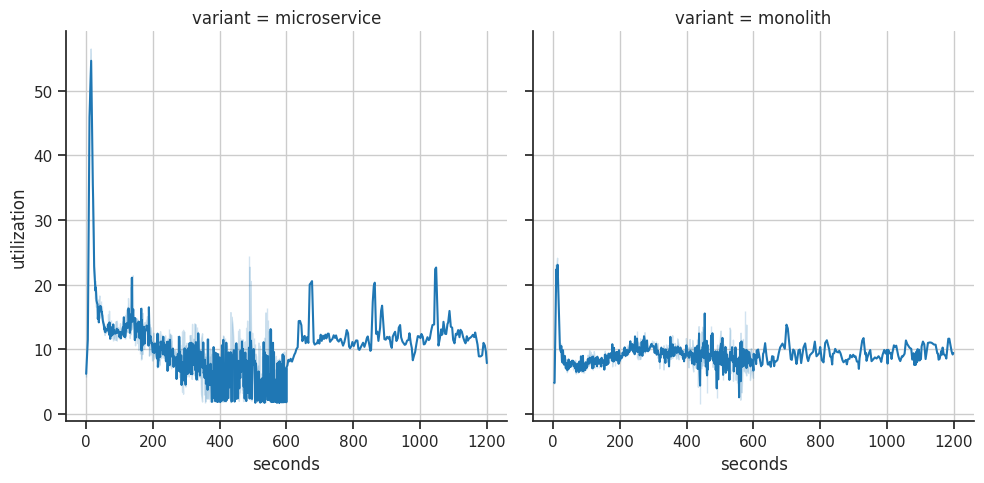

In [ ]:
def get_cpu_peaks(df, order=1):
    df['utilization'] = df.loc[:, ['{mode="iowait"}', '{mode="irq"}', '{mode="nice"}', '{mode="softirq"}', '{mode="steal"}', '{mode="system"}','{mode="user"}']].sum(axis=1)
    return df.iloc[argrelmax(df['utilization'].values, order=order)[0]]

CPU_UTILIZATION_PEAKS = pd.concat([
        get_cpu_peaks(prepare_dataframe(Q_CPU_UTILIZATION, data_measurement.loc[data_measurement['Variant'] == v]).assign(variant=v)) for v in VARIANTS
    ])
CPU_UTILIZATION_PEAKS = CPU_UTILIZATION_PEAKS.loc[:, ['seconds', 'variant', 'utilization']]
f = plt.figure(figsize=(10,3))
sns.relplot(
    data=CPU_UTILIZATION_PEAKS, x="seconds", y="utilization", col="variant", kind="line"
)
fg.set_xlabels("Time (s)")
fg.set_ylabels("CPU Utilization (%)")
plt.show(f)